# **Data - 나영**

### **Load Modules**

In [1]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Subset


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [4]:
batch_size = 128
num_epochs = 20
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [5]:
train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    # 무작위로 -15도에서 +15도 사이 회전
    transforms.RandomRotation(degrees=15),
    # 밝기, 대비, 채도, 색조 변형 (임의 값)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

### **Load Data**

**Splitting th training data**

In [6]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Stratified 방식으로 train 데이터셋을 train/val로 나누기 위해 라벨 정보 추출
labels = train_val_data.targets  # CIFAR-100 라벨 목록

# StratifiedShuffleSplit을 사용하여 train/validation을 80:20으로 나눕니다.
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# train_index, val_index를 생성
for train_index, val_index in stratified_split.split(train_val_data.data, labels):
    train_data = Subset(train_val_data, train_index)
    val_data = Subset(train_val_data, val_index)

Check train datas distribution

Original dataset class distribution:


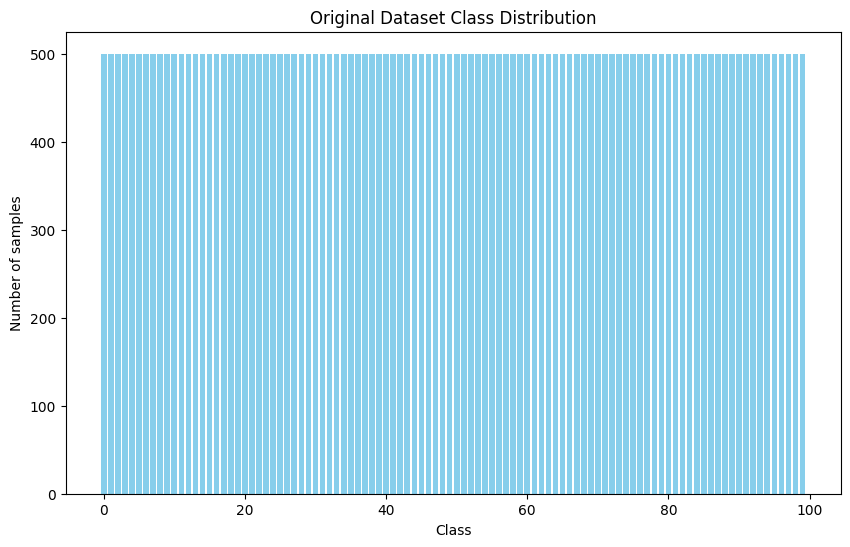


Train dataset class distribution:


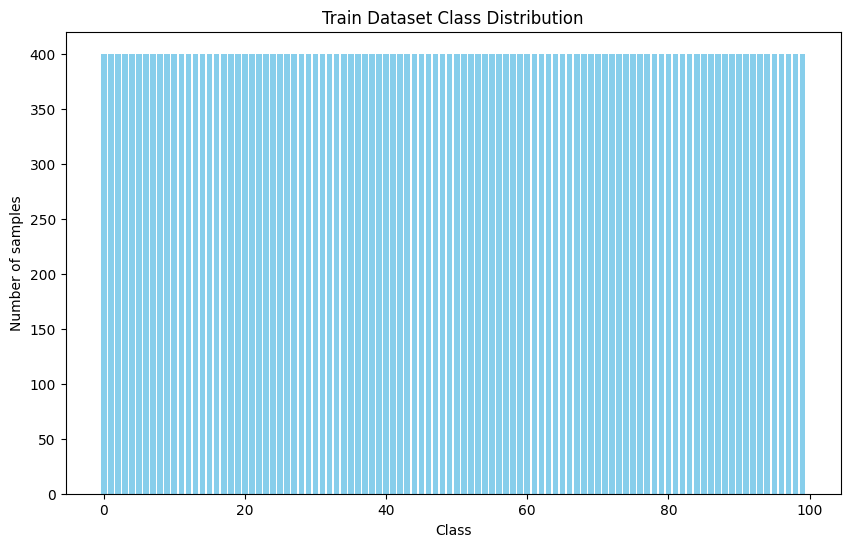


Validation dataset class distribution:


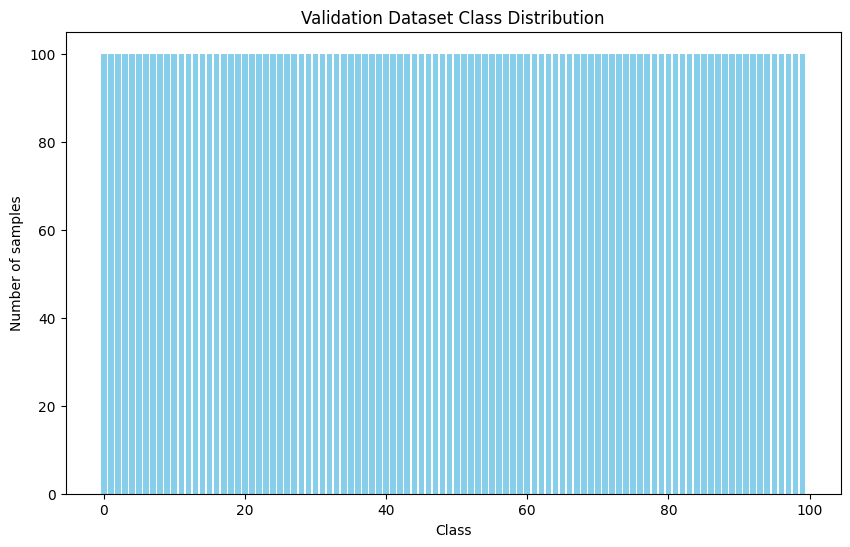

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Subset

# 클래스 분포를 시각화하는 함수
def plot_class_distribution(dataset, labels, title):
    if isinstance(dataset, Subset):
        indices = dataset.indices
        subset_labels = np.array(labels)[indices]
    else:
        subset_labels = labels

    class_counts = Counter(subset_labels)
    classes, counts = zip(*sorted(class_counts.items()))  # 클래스 번호 순서대로 정렬

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.show()

# 원본 데이터셋의 클래스 분포 시각화
print("Original dataset class distribution:")
plot_class_distribution(train_val_data, labels, "Original Dataset Class Distribution")

# Train 데이터셋의 클래스 분포 시각화
print("\nTrain dataset class distribution:")
plot_class_distribution(train_data, labels, "Train Dataset Class Distribution")

# Validation 데이터셋의 클래스 분포 시각화
print("\nValidation dataset class distribution:")
plot_class_distribution(val_data, labels, "Validation Dataset Class Distribution")


**Define DataLoader**

In [11]:
# DataLoader 설정
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# **Model - 하연**

models 폴더에 만들고 import 하는 식으로 해주세요

**Training Loop**

In [14]:
print("use:", device)

# 모델 import 하기
# from models.resnetRS import ResNetRS50
# from models import resnetRS
from models import efficientNet
from models.efficientNet import EfficientNet

# 모델 초기화
net = efficientNet.EfficientNet()

# 모델을 GPU로 이동
net.to(device)

# 모델 구조 출력
print(summary(net, (3, 224, 224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
   SwishActivation-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           1,024
       BatchNorm2d-5         [-1, 32, 112, 112]              64
   SwishActivation-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
       BatchNorm2d-8         [-1, 32, 112, 112]              64
   SwishActivation-9         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
           Linear-11                    [-1, 8]             264
             ReLU-12                    [-1, 8]               0
           Linear-13                   [-1, 32]             288
          Sigmoid-14       

### **Loss and Optimizer**

In [15]:
# 손실함수 초기화
criterion = nn.CrossEntropyLoss()

# 옵티마이저 초기화
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]}]


# **Train - 하연**

### **Model Train**

In [16]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [17]:
# save_path = "./runs/resnet_18/checkpoints"
# early_stopping = EarlyStopping(save_path)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [18]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [19]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            
            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(testloader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(testloader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset)
    
    return test_loss, accuracy

### **Per-Epoch Activity**

In [20]:
# Per-Epoch Activity 코드
for epoch in tqdm(range(1, num_epochs + 1)):
    # 모델 학습
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    
    # 테스트 평가
    test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
    
    # TensorBoard에 테스트 결과 기록
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)

    # 현재 epoch 결과 출력
    print(f"Epoch [{epoch}/{num_epochs}]   Loss: {test_loss:.4f}   Accuracy: {test_accuracy*100:.2f}%")

# TensorBoard writer 닫기
writer.close()

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.6466
Batch [60/313], Loss: 4.6349
Batch [90/313], Loss: 4.6293
Batch [120/313], Loss: 4.5360
Batch [150/313], Loss: 4.5498
Batch [180/313], Loss: 4.5761
Batch [210/313], Loss: 4.5321
Batch [240/313], Loss: 4.5141
Batch [270/313], Loss: 4.5259
Batch [300/313], Loss: 4.4235
Epoch [1/20], Loss: 4.5716
Validation loss decreased (inf --> 4.571617).  Saving model ...
Batch [30/313], Loss: 4.3439
Batch [60/313], Loss: 4.4229
Batch [90/313], Loss: 4.4189
Batch [120/313], Loss: 4.3297
Batch [150/313], Loss: 4.3747
Batch [180/313], Loss: 4.1262
Batch [210/313], Loss: 4.2377
Batch [240/313], Loss: 4.1177
Batch [270/313], Loss: 4.1863
Batch [300/313], Loss: 4.2737
Epoch [2/20], Loss: 4.2671
Validation loss decreased (4.571617 --> 4.267093).  Saving model ...
Batch [30/313], Loss: 4.2060
Batch [60/313], Loss: 3.9721
Batch [90/313], Loss: 4.0382
Batch [120/313], Loss: 4.0890
Batch [150/313], Loss: 4.0109
Batch [180/313], Loss: 4.0116
Batch [210/313], Loss: 4.1934
Batch [240/3

  5%|██                                      | 1/20 [23:27<7:25:40, 1407.40s/it]

Epoch [1/20]   Loss: 2.9229   Accuracy: 27.37%
Batch [30/313], Loss: 3.0685
Batch [60/313], Loss: 2.8553
Batch [90/313], Loss: 3.1370
Batch [120/313], Loss: 2.8980
Batch [150/313], Loss: 2.8095
Batch [180/313], Loss: 3.1143
Batch [210/313], Loss: 2.9950
Batch [240/313], Loss: 3.2338
Batch [270/313], Loss: 3.0470
Batch [300/313], Loss: 3.0304
Epoch [1/20], Loss: 2.9837
Validation loss decreased (3.014839 --> 2.983719).  Saving model ...
Batch [30/313], Loss: 2.6869
Batch [60/313], Loss: 3.1254
Batch [90/313], Loss: 2.9286
Batch [120/313], Loss: 2.8528
Batch [150/313], Loss: 3.1816
Batch [180/313], Loss: 3.1451
Batch [210/313], Loss: 3.0382
Batch [240/313], Loss: 3.0035
Batch [270/313], Loss: 2.9164
Batch [300/313], Loss: 2.9252
Epoch [2/20], Loss: 2.9558
Validation loss decreased (2.983719 --> 2.955828).  Saving model ...
Batch [30/313], Loss: 2.8573
Batch [60/313], Loss: 2.9200
Batch [90/313], Loss: 3.0024
Batch [120/313], Loss: 3.3556
Batch [150/313], Loss: 3.1431
Batch [180/313], Los

 10%|████                                    | 2/20 [50:08<7:36:20, 1521.16s/it]

Epoch [2/20]   Loss: 2.5771   Accuracy: 35.17%
Batch [30/313], Loss: 2.4538
Batch [60/313], Loss: 2.6232
Batch [90/313], Loss: 2.4808
Batch [120/313], Loss: 2.5905
Batch [150/313], Loss: 2.3634
Batch [180/313], Loss: 2.3710
Batch [210/313], Loss: 2.4057
Batch [240/313], Loss: 2.2141
Batch [270/313], Loss: 2.4481
Batch [300/313], Loss: 2.1581
Epoch [1/20], Loss: 2.4259
Validation loss decreased (2.453974 --> 2.425924).  Saving model ...
Batch [30/313], Loss: 2.2154
Batch [60/313], Loss: 2.2683
Batch [90/313], Loss: 2.3529
Batch [120/313], Loss: 2.7588
Batch [150/313], Loss: 2.2913
Batch [180/313], Loss: 2.3225
Batch [210/313], Loss: 2.3930
Batch [240/313], Loss: 2.4130
Batch [270/313], Loss: 2.5254
Batch [300/313], Loss: 2.3257
Epoch [2/20], Loss: 2.3997
Validation loss decreased (2.425924 --> 2.399746).  Saving model ...
Batch [30/313], Loss: 2.1458
Batch [60/313], Loss: 2.3404
Batch [90/313], Loss: 2.5106
Batch [120/313], Loss: 2.4598
Batch [150/313], Loss: 2.3861
Batch [180/313], Los

 15%|█████▋                                | 3/20 [1:17:23<7:25:42, 1573.11s/it]

Epoch [3/20]   Loss: 2.5184   Accuracy: 38.16%
Batch [30/313], Loss: 2.2099
Batch [60/313], Loss: 2.0006
Batch [90/313], Loss: 1.9815
Batch [120/313], Loss: 1.7880
Batch [150/313], Loss: 1.9327
Batch [180/313], Loss: 2.3116
Batch [210/313], Loss: 2.1416
Batch [240/313], Loss: 2.2171
Batch [270/313], Loss: 2.0849
Batch [300/313], Loss: 2.0495
Epoch [1/20], Loss: 1.9739
Validation loss decreased (1.976844 --> 1.973937).  Saving model ...
Batch [30/313], Loss: 1.8748
Batch [60/313], Loss: 2.1915
Batch [90/313], Loss: 2.0061
Batch [120/313], Loss: 1.8284
Batch [150/313], Loss: 2.1469
Batch [180/313], Loss: 1.9474
Batch [210/313], Loss: 2.0230
Batch [240/313], Loss: 1.9431
Batch [270/313], Loss: 1.9419
Batch [300/313], Loss: 2.2549
Epoch [2/20], Loss: 1.9333
Validation loss decreased (1.973937 --> 1.933286).  Saving model ...
Batch [30/313], Loss: 1.8135
Batch [60/313], Loss: 1.8096
Batch [90/313], Loss: 1.7466
Batch [120/313], Loss: 1.7684
Batch [150/313], Loss: 1.8070
Batch [180/313], Los

 20%|███████▌                              | 4/20 [1:44:54<7:07:41, 1603.87s/it]

Epoch [4/20]   Loss: 2.5986   Accuracy: 38.74%
Batch [30/313], Loss: 1.4687
Batch [60/313], Loss: 1.7680
Batch [90/313], Loss: 1.5605
Batch [120/313], Loss: 1.5715
Batch [150/313], Loss: 1.6598
Batch [180/313], Loss: 1.6121
Batch [210/313], Loss: 1.4475
Batch [240/313], Loss: 1.3664
Batch [270/313], Loss: 1.5479
Batch [300/313], Loss: 1.6668
Epoch [1/20], Loss: 1.5057
Validation loss decreased (1.525820 --> 1.505737).  Saving model ...
Batch [30/313], Loss: 1.5958
Batch [60/313], Loss: 1.3470
Batch [90/313], Loss: 1.6995
Batch [120/313], Loss: 1.4267
Batch [150/313], Loss: 1.4227
Batch [180/313], Loss: 1.7008
Batch [210/313], Loss: 1.5133
Batch [240/313], Loss: 1.5950
Batch [270/313], Loss: 1.7831
Batch [300/313], Loss: 1.5655
Epoch [2/20], Loss: 1.4786
Validation loss decreased (1.505737 --> 1.478598).  Saving model ...
Batch [30/313], Loss: 1.3382
Batch [60/313], Loss: 1.5275
Batch [90/313], Loss: 1.2229
Batch [120/313], Loss: 1.3069
Batch [150/313], Loss: 1.5758
Batch [180/313], Los

 25%|█████████▌                            | 5/20 [2:12:21<6:44:52, 1619.52s/it]

Epoch [5/20]   Loss: 2.8221   Accuracy: 38.37%
Batch [30/313], Loss: 1.1171
Batch [60/313], Loss: 0.9326
Batch [90/313], Loss: 1.0395
Batch [120/313], Loss: 1.1046
Batch [150/313], Loss: 0.9822
Batch [180/313], Loss: 0.9391
Batch [210/313], Loss: 1.1698
Batch [240/313], Loss: 0.9699
Batch [270/313], Loss: 1.2291
Batch [300/313], Loss: 1.4278
Epoch [1/20], Loss: 1.0685
Validation loss decreased (1.092912 --> 1.068479).  Saving model ...
Batch [30/313], Loss: 0.8838
Batch [60/313], Loss: 0.9821
Batch [90/313], Loss: 0.9829
Batch [120/313], Loss: 1.0970
Batch [150/313], Loss: 1.1132
Batch [180/313], Loss: 1.2587
Batch [210/313], Loss: 1.1191
Batch [240/313], Loss: 1.0472
Batch [270/313], Loss: 0.9965
Batch [300/313], Loss: 1.0418
Epoch [2/20], Loss: 1.0459
Validation loss decreased (1.068479 --> 1.045882).  Saving model ...
Batch [30/313], Loss: 0.9949
Batch [60/313], Loss: 1.0973
Batch [90/313], Loss: 0.9012
Batch [120/313], Loss: 1.1774
Batch [150/313], Loss: 0.9089
Batch [180/313], Los

 30%|███████████▍                          | 6/20 [2:39:43<6:19:40, 1627.19s/it]

Epoch [6/20]   Loss: 3.0497   Accuracy: 38.36%
Batch [30/313], Loss: 0.7334
Batch [60/313], Loss: 0.6480
Batch [90/313], Loss: 0.6982
Batch [120/313], Loss: 0.6827
Batch [150/313], Loss: 0.7052
Batch [180/313], Loss: 0.7789
Batch [210/313], Loss: 0.6161
Batch [240/313], Loss: 0.8150
Batch [270/313], Loss: 0.6413
Batch [300/313], Loss: 0.7497
Epoch [1/20], Loss: 0.7375
Validation loss decreased (0.747992 --> 0.737529).  Saving model ...
Batch [30/313], Loss: 0.6344
Batch [60/313], Loss: 0.6364
Batch [90/313], Loss: 0.5545
Batch [120/313], Loss: 0.6557
Batch [150/313], Loss: 0.6687
Batch [180/313], Loss: 0.6918
Batch [210/313], Loss: 0.6982
Batch [240/313], Loss: 0.6202
Batch [270/313], Loss: 0.7817
Batch [300/313], Loss: 0.8140
Epoch [2/20], Loss: 0.7231
Validation loss decreased (0.737529 --> 0.723133).  Saving model ...
Batch [30/313], Loss: 0.7692
Batch [60/313], Loss: 0.7757
Batch [90/313], Loss: 0.7295
Batch [120/313], Loss: 0.6876
Batch [150/313], Loss: 0.5996
Batch [180/313], Los

 35%|█████████████▎                        | 7/20 [3:06:59<5:53:09, 1629.94s/it]

Epoch [7/20]   Loss: 3.2684   Accuracy: 38.34%
Batch [30/313], Loss: 0.5243
Batch [60/313], Loss: 0.3359
Batch [90/313], Loss: 0.6163
Batch [120/313], Loss: 0.5561
Batch [150/313], Loss: 0.6413
Batch [180/313], Loss: 0.5703
Batch [210/313], Loss: 0.4572
Batch [240/313], Loss: 0.5474
Batch [270/313], Loss: 0.3445
Batch [300/313], Loss: 0.8108
Epoch [1/20], Loss: 0.5019
Validation loss decreased (0.515204 --> 0.501902).  Saving model ...
Batch [30/313], Loss: 0.4333
Batch [60/313], Loss: 0.4054
Batch [90/313], Loss: 0.6990
Batch [120/313], Loss: 0.3248
Batch [150/313], Loss: 0.7065
Batch [180/313], Loss: 0.5708
Batch [210/313], Loss: 0.4668
Batch [240/313], Loss: 0.4546
Batch [270/313], Loss: 0.7125
Batch [300/313], Loss: 0.5010
Epoch [2/20], Loss: 0.4913
Validation loss decreased (0.501902 --> 0.491320).  Saving model ...
Batch [30/313], Loss: 0.5161
Batch [60/313], Loss: 0.3317
Batch [90/313], Loss: 0.4561
Batch [120/313], Loss: 0.4982
Batch [150/313], Loss: 0.4153
Batch [180/313], Los

 40%|███████████████▏                      | 8/20 [3:34:27<5:27:07, 1635.66s/it]

Epoch [8/20]   Loss: 3.4139   Accuracy: 38.29%
Batch [30/313], Loss: 0.3533
Batch [60/313], Loss: 0.3304
Batch [90/313], Loss: 0.3290
Batch [120/313], Loss: 0.2873
Batch [150/313], Loss: 0.3917
Batch [180/313], Loss: 0.4412
Batch [210/313], Loss: 0.3472
Batch [240/313], Loss: 0.4083
Batch [270/313], Loss: 0.2992
Batch [300/313], Loss: 0.3372
Epoch [1/20], Loss: 0.3582
Validation loss decreased (0.369885 --> 0.358242).  Saving model ...
Batch [30/313], Loss: 0.4498
Batch [60/313], Loss: 0.3538
Batch [90/313], Loss: 0.3856
Batch [120/313], Loss: 0.2703
Batch [150/313], Loss: 0.3754
Batch [180/313], Loss: 0.2993
Batch [210/313], Loss: 0.3084
Batch [240/313], Loss: 0.3889
Batch [270/313], Loss: 0.3833
Batch [300/313], Loss: 0.2748
Epoch [2/20], Loss: 0.3694
EarlyStopping counter: 1 out of 5
Batch [30/313], Loss: 0.4304
Batch [60/313], Loss: 0.2539
Batch [90/313], Loss: 0.4343
Batch [120/313], Loss: 0.2631
Batch [150/313], Loss: 0.4817
Batch [180/313], Loss: 0.2657
Batch [210/313], Loss: 0.

 45%|█████████████████                     | 9/20 [4:01:42<4:59:51, 1635.57s/it]

Epoch [9/20]   Loss: 3.5230   Accuracy: 38.97%
Batch [30/313], Loss: 0.1977
Batch [60/313], Loss: 0.2696
Batch [90/313], Loss: 0.2064
Batch [120/313], Loss: 0.3741
Batch [150/313], Loss: 0.2577
Batch [180/313], Loss: 0.3001
Batch [210/313], Loss: 0.3438
Batch [240/313], Loss: 0.1860
Batch [270/313], Loss: 0.2343
Batch [300/313], Loss: 0.3911
Epoch [1/20], Loss: 0.2765
EarlyStopping counter: 2 out of 5
Batch [30/313], Loss: 0.2384
Batch [60/313], Loss: 0.2926
Batch [90/313], Loss: 0.2747
Batch [120/313], Loss: 0.2965
Batch [150/313], Loss: 0.2567
Batch [180/313], Loss: 0.3483
Batch [210/313], Loss: 0.3754
Batch [240/313], Loss: 0.3477
Batch [270/313], Loss: 0.2220
Batch [300/313], Loss: 0.3504
Epoch [2/20], Loss: 0.2741
Validation loss decreased (0.275279 --> 0.274129).  Saving model ...
Batch [30/313], Loss: 0.2070
Batch [60/313], Loss: 0.2076
Batch [90/313], Loss: 0.2475
Batch [120/313], Loss: 0.2266
Batch [150/313], Loss: 0.4084
Batch [180/313], Loss: 0.3262
Batch [210/313], Loss: 0.

 50%|██████████████████▌                  | 10/20 [4:29:03<4:32:52, 1637.22s/it]

Epoch [10/20]   Loss: 3.6415   Accuracy: 39.11%
Batch [30/313], Loss: 0.0947
Batch [60/313], Loss: 0.2006
Batch [90/313], Loss: 0.1822
Batch [120/313], Loss: 0.1364
Batch [150/313], Loss: 0.1827
Batch [180/313], Loss: 0.2669
Batch [210/313], Loss: 0.1532
Batch [240/313], Loss: 0.1669
Batch [270/313], Loss: 0.2641
Batch [300/313], Loss: 0.2310
Epoch [1/20], Loss: 0.2182
Validation loss decreased (0.220639 --> 0.218168).  Saving model ...
Batch [30/313], Loss: 0.2168
Batch [60/313], Loss: 0.2091
Batch [90/313], Loss: 0.1774
Batch [120/313], Loss: 0.1865
Batch [150/313], Loss: 0.1759
Batch [180/313], Loss: 0.1421
Batch [210/313], Loss: 0.1786
Batch [240/313], Loss: 0.2280
Batch [270/313], Loss: 0.2121
Batch [300/313], Loss: 0.2091
Epoch [2/20], Loss: 0.2062
Validation loss decreased (0.218168 --> 0.206172).  Saving model ...
Batch [30/313], Loss: 0.2061
Batch [60/313], Loss: 0.1987
Batch [90/313], Loss: 0.1190
Batch [120/313], Loss: 0.2421
Batch [150/313], Loss: 0.2574
Batch [180/313], Lo

 55%|████████████████████▎                | 11/20 [4:56:25<4:05:49, 1638.81s/it]

Epoch [11/20]   Loss: 3.7433   Accuracy: 38.66%
Batch [30/313], Loss: 0.0839
Batch [60/313], Loss: 0.1664
Batch [90/313], Loss: 0.2175
Batch [120/313], Loss: 0.1891
Batch [150/313], Loss: 0.1708
Batch [180/313], Loss: 0.1681
Batch [210/313], Loss: 0.1548
Batch [240/313], Loss: 0.1629
Batch [270/313], Loss: 0.1563
Batch [300/313], Loss: 0.1511
Epoch [1/20], Loss: 0.1759
EarlyStopping counter: 2 out of 5
Batch [30/313], Loss: 0.1133
Batch [60/313], Loss: 0.1813
Batch [90/313], Loss: 0.2061
Batch [120/313], Loss: 0.1848
Batch [150/313], Loss: 0.2317
Batch [180/313], Loss: 0.1332
Batch [210/313], Loss: 0.1675
Batch [240/313], Loss: 0.2455
Batch [270/313], Loss: 0.1545
Batch [300/313], Loss: 0.1815
Epoch [2/20], Loss: 0.1724
Validation loss decreased (0.174125 --> 0.172390).  Saving model ...
Batch [30/313], Loss: 0.1296
Batch [60/313], Loss: 0.1465
Batch [90/313], Loss: 0.1479
Batch [120/313], Loss: 0.2312
Batch [150/313], Loss: 0.1861
Batch [180/313], Loss: 0.1464
Batch [210/313], Loss: 0

 60%|██████████████████████▏              | 12/20 [5:23:49<3:38:41, 1640.18s/it]

Epoch [12/20]   Loss: 3.8292   Accuracy: 38.30%
Batch [30/313], Loss: 0.1222
Batch [60/313], Loss: 0.1129
Batch [90/313], Loss: 0.1651
Batch [120/313], Loss: 0.0627
Batch [150/313], Loss: 0.1268
Batch [180/313], Loss: 0.1073
Batch [210/313], Loss: 0.2135
Batch [240/313], Loss: 0.1061
Batch [270/313], Loss: 0.1536
Batch [300/313], Loss: 0.1576
Epoch [1/20], Loss: 0.1467
Validation loss decreased (0.147251 --> 0.146691).  Saving model ...
Batch [30/313], Loss: 0.0711
Batch [60/313], Loss: 0.1556
Batch [90/313], Loss: 0.1686
Batch [120/313], Loss: 0.1744
Batch [150/313], Loss: 0.1115
Batch [180/313], Loss: 0.1591
Batch [210/313], Loss: 0.2943
Batch [240/313], Loss: 0.1607
Batch [270/313], Loss: 0.0586
Batch [300/313], Loss: 0.1673
Epoch [2/20], Loss: 0.1447
Validation loss decreased (0.146691 --> 0.144736).  Saving model ...
Batch [30/313], Loss: 0.0965
Batch [60/313], Loss: 0.1120
Batch [90/313], Loss: 0.0763
Batch [120/313], Loss: 0.1504
Batch [150/313], Loss: 0.1550
Batch [180/313], Lo

 65%|████████████████████████             | 13/20 [5:34:46<2:36:37, 1342.43s/it]

Epoch [13/20]   Loss: 3.8217   Accuracy: 39.21%
Batch [30/313], Loss: 0.0782
Batch [60/313], Loss: 0.1285
Batch [90/313], Loss: 0.1492
Batch [120/313], Loss: 0.1418
Batch [150/313], Loss: 0.1693
Batch [180/313], Loss: 0.2058
Batch [210/313], Loss: 0.2146
Batch [240/313], Loss: 0.1258
Batch [270/313], Loss: 0.1151
Batch [300/313], Loss: 0.1466
Epoch [1/20], Loss: 0.1370
EarlyStopping counter: 6 out of 5
Early stopping


 70%|██████████████████████████▌           | 14/20 [5:36:10<1:36:15, 962.51s/it]

Epoch [14/20]   Loss: 3.8288   Accuracy: 39.39%
Batch [30/313], Loss: 0.1375
Batch [60/313], Loss: 0.0598
Batch [90/313], Loss: 0.1459
Batch [120/313], Loss: 0.1285
Batch [150/313], Loss: 0.0773
Batch [180/313], Loss: 0.0824
Batch [210/313], Loss: 0.1330
Batch [240/313], Loss: 0.1809
Batch [270/313], Loss: 0.2017
Batch [300/313], Loss: 0.1414
Epoch [1/20], Loss: 0.1332
Validation loss decreased (0.134610 --> 0.133232).  Saving model ...
Early stopping


 75%|██████████████████████████████          | 15/20 [5:37:35<58:09, 697.98s/it]

Epoch [15/20]   Loss: 3.8648   Accuracy: 38.74%
Batch [30/313], Loss: 0.1389
Batch [60/313], Loss: 0.1287
Batch [90/313], Loss: 0.0929
Batch [120/313], Loss: 0.0723
Batch [150/313], Loss: 0.1991
Batch [180/313], Loss: 0.2438
Batch [210/313], Loss: 0.2098
Batch [240/313], Loss: 0.1451
Batch [270/313], Loss: 0.1318
Batch [300/313], Loss: 0.1851
Epoch [1/20], Loss: 0.1384
EarlyStopping counter: 1 out of 5
Early stopping


 80%|████████████████████████████████        | 16/20 [5:39:00<34:13, 513.39s/it]

Epoch [16/20]   Loss: 3.8202   Accuracy: 39.52%
Batch [30/313], Loss: 0.1008
Batch [60/313], Loss: 0.0939
Batch [90/313], Loss: 0.2563
Batch [120/313], Loss: 0.1023
Batch [150/313], Loss: 0.0992
Batch [180/313], Loss: 0.1445
Batch [210/313], Loss: 0.0864
Batch [240/313], Loss: 0.0701
Batch [270/313], Loss: 0.1068
Batch [300/313], Loss: 0.2649
Epoch [1/20], Loss: 0.1272
Validation loss decreased (0.133232 --> 0.127155).  Saving model ...
Early stopping


 85%|██████████████████████████████████      | 17/20 [5:40:25<19:13, 384.55s/it]

Epoch [17/20]   Loss: 3.8331   Accuracy: 39.28%
Batch [30/313], Loss: 0.1753
Batch [60/313], Loss: 0.1456
Batch [90/313], Loss: 0.0973
Batch [120/313], Loss: 0.1081
Batch [150/313], Loss: 0.1312
Batch [180/313], Loss: 0.1315
Batch [210/313], Loss: 0.1312
Batch [240/313], Loss: 0.1354
Batch [270/313], Loss: 0.1773
Batch [300/313], Loss: 0.1029
Epoch [1/20], Loss: 0.1312
EarlyStopping counter: 1 out of 5
Early stopping


 90%|████████████████████████████████████    | 18/20 [5:41:50<09:48, 294.43s/it]

Epoch [18/20]   Loss: 3.8154   Accuracy: 39.46%
Batch [30/313], Loss: 0.0997
Batch [60/313], Loss: 0.1699
Batch [90/313], Loss: 0.1385
Batch [120/313], Loss: 0.0623
Batch [150/313], Loss: 0.1387
Batch [180/313], Loss: 0.0818
Batch [210/313], Loss: 0.1232
Batch [240/313], Loss: 0.1408
Batch [270/313], Loss: 0.1259
Batch [300/313], Loss: 0.1557
Epoch [1/20], Loss: 0.1283
EarlyStopping counter: 2 out of 5
Early stopping


 95%|██████████████████████████████████████  | 19/20 [5:43:14<03:51, 231.27s/it]

Epoch [19/20]   Loss: 3.8482   Accuracy: 38.86%
Batch [30/313], Loss: 0.2397
Batch [60/313], Loss: 0.1151
Batch [90/313], Loss: 0.1351
Batch [120/313], Loss: 0.1264
Batch [150/313], Loss: 0.1543
Batch [180/313], Loss: 0.0960
Batch [210/313], Loss: 0.0780
Batch [240/313], Loss: 0.1369
Batch [270/313], Loss: 0.0656
Batch [300/313], Loss: 0.1221
Epoch [1/20], Loss: 0.1252
Validation loss decreased (0.127155 --> 0.125208).  Saving model ...
Early stopping


100%|███████████████████████████████████████| 20/20 [5:44:39<00:00, 1033.96s/it]

Epoch [20/20]   Loss: 3.8599   Accuracy: 39.00%


### **Result**

In [21]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 20   Loss : 3.859919033432007   Accuracy : 0.39


# Test - 나영(Accuracy) 현욱(Analysis)

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %d %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 39 %


**Visualization of average loss(수정 필요)**

**Top-1 Accuracy**

**Top-5 Accuracy**

# Data Analysis - 현욱

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./runs/resnet_18/tensorboard --port=8202 --host=0.0.0.0

### **Classes**

In [ ]:
classes = train_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

In [ ]:
print(len(classes), len(coarse_classes))

##### **Fine_to_coarse_mapping**

In [ ]:
# CIFAR-100 세부 클래스(fine classes)와 상위 클래스(coarse classes) 매핑
fine_to_coarse_mapping = {
    # aquatic mammals
    'beaver': 'aquatic mammals',
    'dolphin': 'aquatic mammals',
    'otter': 'aquatic mammals',
    'seal': 'aquatic mammals',
    'whale': 'aquatic mammals',
    
    # fish
    'aquarium fish': 'fish',
    'flatfish': 'fish',
    'ray': 'fish',
    'shark': 'fish',
    'trout': 'fish',
    
    # flowers
    'orchids': 'flowers',
    'poppies': 'flowers',
    'roses': 'flowers',
    'sunflowers': 'flowers',
    'tulips': 'flowers',
    
    # food containers
    'bottles': 'food containers',
    'bowls': 'food containers',
    'cans': 'food containers',
    'cups': 'food containers',
    'plates': 'food containers',
    
    # fruit and vegetables
    'apples': 'fruit and vegetables',
    'mushrooms': 'fruit and vegetables',
    'oranges': 'fruit and vegetables',
    'pears': 'fruit and vegetables',
    'sweet peppers': 'fruit and vegetables',
    
    # household electrical devices
    'clock': 'household electrical devices',
    'computer keyboard': 'household electrical devices',
    'lamp': 'household electrical devices',
    'telephone': 'household electrical devices',
    'television': 'household electrical devices',
    
    # household furniture
    'bed': 'household furniture',
    'chair': 'household furniture',
    'couch': 'household furniture',
    'table': 'household furniture',
    'wardrobe': 'household furniture',
    
    # insects
    'bee': 'insects',
    'beetle': 'insects',
    'butterfly': 'insects',
    'caterpillar': 'insects',
    'cockroach': 'insects',
    
    # large carnivores
    'bear': 'large carnivores',
    'leopard': 'large carnivores',
    'lion': 'large carnivores',
    'tiger': 'large carnivores',
    'wolf': 'large carnivores',
    
    # large man-made outdoor things
    'bridge': 'large man-made outdoor things',
    'castle': 'large man-made outdoor things',
    'house': 'large man-made outdoor things',
    'road': 'large man-made outdoor things',
    'skyscraper': 'large man-made outdoor things',
    
    # large natural outdoor scenes
    'cloud': 'large natural outdoor scenes',
    'forest': 'large natural outdoor scenes',
    'mountain': 'large natural outdoor scenes',
    'plain': 'large natural outdoor scenes',
    'sea': 'large natural outdoor scenes',
    
    # large omnivores and herbivores
    'camel': 'large omnivores and herbivores',
    'cattle': 'large omnivores and herbivores',
    'chimpanzee': 'large omnivores and herbivores',
    'elephant': 'large omnivores and herbivores',
    'kangaroo': 'large omnivores and herbivores',
    
    # medium-sized mammals
    'fox': 'medium-sized mammals',
    'porcupine': 'medium-sized mammals',
    'possum': 'medium-sized mammals',
    'raccoon': 'medium-sized mammals',
    'skunk': 'medium-sized mammals',
    
    # non-insect invertebrates
    'crab': 'non-insect invertebrates',
    'lobster': 'non-insect invertebrates',
    'snail': 'non-insect invertebrates',
    'spider': 'non-insect invertebrates',
    'worm': 'non-insect invertebrates',
    
    # people
    'baby': 'people',
    'boy': 'people',
    'girl': 'people',
    'man': 'people',
    'woman': 'people',
    
    # reptiles
    'crocodile': 'reptiles',
    'dinosaur': 'reptiles',
    'lizard': 'reptiles',
    'snake': 'reptiles',
    'turtle': 'reptiles',
    
    # small mammals
    'hamster': 'small mammals',
    'mouse': 'small mammals',
    'rabbit': 'small mammals',
    'shrew': 'small mammals',
    'squirrel': 'small mammals',
    
    # trees
    'maple': 'trees',
    'oak': 'trees',
    'palm': 'trees',
    'pine': 'trees',
    'willow': 'trees',
    
    # vehicles 1
    'bicycle': 'vehicles 1',
    'bus': 'vehicles 1',
    'motorcycle': 'vehicles 1',
    'pickup truck': 'vehicles 1',
    'train': 'vehicles 1',
    
    # vehicles 2
    'lawn-mower': 'vehicles 2',
    'rocket': 'vehicles 2',
    'streetcar': 'vehicles 2',
    'tank': 'vehicles 2',
    'tractor': 'vehicles 2'
}


### **Confusion Matrix**

In [ ]:
# y_pred = []
# y_true = []

# # iterate over test data
# for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
#     #print('iter val', i)
#     x = x.to(device)
#     y = y.to(device)
#     z = net(x)
#     _, yhat = torch.max(z, 1)
#     pred = yhat.data.cpu().numpy()
#     y_pred.extend(pred) # Save Prediction

#     labels = y.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (128,70))
# sns.heatmap(df_cm, annot=True)
# plt.title('Confusion Matrix of ResNet (CIFAR100)')
# plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

### **Confusion Matrix - Coarse**

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    
    # Save Prediction and convert to superclasses
    pred = yhat.data.cpu().numpy()
    super_pred = [fine_to_superclass[p] for p in pred]
    y_pred.extend(super_pred)
    
    # Save Truth and convert to superclasses
    labels = y.data.cpu().numpy()
    super_labels = [fine_to_superclass[l] for l in labels]
    y_true.extend(super_labels)

# Build confusion matrix for superclasses
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Normalize confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=coarse_classes,
                     columns=coarse_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix of ResNet (CIFAR-100 Superclass)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100_superclass.jpg')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

### **Classification Report**

In [ ]:
print(f"Super Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

In [24]:
# 모델 가중치를 runs 폴더에 저장
torch.save(net.state_dict(), f'runs/efficientnetb0_model.pth')
print("finish!")

finish!
